In [ ]:
import os
import sys
import glob
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import unicodedata
import string
import copy
#writer = SummaryWriter("runs/word-classification")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Loading the data

In [ ]:
# Define the folder path
data_folder = os.path.join("/content/drive/MyDrive/csv files/names")

# Get all `.txt` file paths in the folder
file_paths = glob.glob(os.path.join(data_folder, "*.txt"))

# Print file paths
print(file_paths)

['/content/drive/MyDrive/csv files/names/Arabic.txt', '/content/drive/MyDrive/csv files/names/Chinese.txt', '/content/drive/MyDrive/csv files/names/Czech.txt', '/content/drive/MyDrive/csv files/names/English.txt', '/content/drive/MyDrive/csv files/names/Dutch.txt', '/content/drive/MyDrive/csv files/names/German.txt', '/content/drive/MyDrive/csv files/names/Irish.txt', '/content/drive/MyDrive/csv files/names/French.txt', '/content/drive/MyDrive/csv files/names/Greek.txt', '/content/drive/MyDrive/csv files/names/Russian.txt', '/content/drive/MyDrive/csv files/names/Portuguese.txt', '/content/drive/MyDrive/csv files/names/Japanese.txt', '/content/drive/MyDrive/csv files/names/Korean.txt', '/content/drive/MyDrive/csv files/names/Polish.txt', '/content/drive/MyDrive/csv files/names/Spanish.txt', '/content/drive/MyDrive/csv files/names/Vietnamese.txt', '/content/drive/MyDrive/csv files/names/Scottish.txt', '/content/drive/MyDrive/csv files/names/Italian.txt']


In [ ]:
words_dict = {}
for file_path in file_paths:
    # Extract language from the file name instead of a fixed split
    language = os.path.basename(file_path).split(".")[0]
    with open(file_path, "r") as file:
        words = file.readlines()
        words = [word.strip().lower() for word in words]
        words_dict[language] = words
print(words_dict['German'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']


In [ ]:
for language, words in words_dict.items():
    print(language, len(words))

Arabic 2000
Chinese 268
Czech 519
English 3668
Dutch 297
German 724
Irish 232
French 277
Greek 203
Russian 9408
Portuguese 74
Japanese 991
Korean 94
Polish 139
Spanish 298
Vietnamese 73
Scottish 100
Italian 709


2. Cleaning text

In [ ]:
characters = set()
for language, words in words_dict.items():
    for word in words:
        characters.update(list(word))
characters = sorted(list(characters))
print(characters)

##There are many accented characers in the dataset which have to transformed into the raw format.##

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'õ', 'ö', 'ù', 'ú', 'ü', 'ą', 'ł', 'ń', 'ś', 'ż']


In [ ]:
c = list('ñ')
c_normalised = list(unicodedata.normalize("NFD", 'ñ'))
print(c, c_normalised)

['ñ'] ['n', '̃']


In [ ]:
characters_normalised = []
for character in characters:
    character_normalised = unicodedata.normalize("NFD", character)[0]
    characters_normalised.append(character_normalised)
print(characters_normalised)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'a', 'a', 'a', 'a', 'c', 'e', 'e', 'e', 'i', 'i', 'n', 'o', 'o', 'o', 'o', 'u', 'u', 'u', 'a', 'ł', 'n', 's', 'z']


In [ ]:
characters_all = list(string.ascii_lowercase + " -',:;")
print(len(characters_all), characters_all)

32 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '-', "'", ',', ':', ';']


In [ ]:
def clean_word(word):
    cleaned_word = ""
    for character in word:
        for character_raw in unicodedata.normalize('NFD', character):
            if character_raw in characters_all:
                cleaned_word += character_raw
    return cleaned_word

In [ ]:
words_dict_cleaned = {}
for language, words in words_dict.items():
    cleaned_words = []
    for word in words:
        cleaned_word = clean_word(word)
        cleaned_words.append(cleaned_word)
    words_dict_cleaned[language] = cleaned_words

In [ ]:
print(words_dict['German'][-10:])
print(words_dict_cleaned['German'][-10:])

print(words_dict['Portuguese'][-10:])
print(words_dict_cleaned['Portuguese'][-10:])

print(words_dict['Korean'][-10:])
print(words_dict_cleaned['Korean'][-10:])

print(words_dict['Vietnamese'][-10:])
print(words_dict_cleaned['Vietnamese'][-10:])

print(words_dict['French'][-10:])
print(words_dict_cleaned['French'][-10:])



['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['wolter', 'worner', 'wornhor', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['santos', 'serafim', 'silva', 'silveira', 'simões', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['santos', 'serafim', 'silva', 'silveira', 'simoes', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['yeon', 'yi', 'yim', 'yoo', 'yoon', 'you', 'youj', 'youn', 'yu', 'yun']
['yeon', 'yi', 'yim', 'yoo', 'yoon', 'you', 'youj', 'youn', 'yu', 'yun']
['ton', 'tong', 'trang', 'trieu', 'trinh', 'truong', 'van', 'vinh', 'vuong', 'vuu']
['ton', 'tong', 'trang', 'trieu', 'trinh', 'truong', 'van', 'vinh', 'vuong', 'vuu']
['travert', 'tremblay', 'tremble', 'victor', 'victors', 'villeneuve', 'vincent', 'vipond', 'voclain', 'yount']
['travert', 'tremblay', 'tremble', 'victor', 'victors', 'villeneuve', 'vincent', 'vipond', 'voclain', 'yount']


In [ ]:
words_dict = copy.deepcopy(words_dict_cleaned)
del words_dict_cleaned

3. Defining utilities

In [ ]:
num_langs = len(words_dict.keys())
num_chars = len(characters_all)
print(num_langs, num_chars)

18 32


In [ ]:
max_timesteps = 0
for language, words in words_dict.items():
    for word in words:
        if len(word) > max_timesteps:
            max_timesteps = len(word)
print(max_timesteps)


20


In [ ]:
lang_to_id = {k:v for k, v in zip(sorted(list(words_dict.keys())), range(len(words_dict.keys())))}
print(lang_to_id)

{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}


In [ ]:
id_to_lang = {v:k for k, v in lang_to_id.items()}
print(id_to_lang)

{0: 'Arabic', 1: 'Chinese', 2: 'Czech', 3: 'Dutch', 4: 'English', 5: 'French', 6: 'German', 7: 'Greek', 8: 'Irish', 9: 'Italian', 10: 'Japanese', 11: 'Korean', 12: 'Polish', 13: 'Portuguese', 14: 'Russian', 15: 'Scottish', 16: 'Spanish', 17: 'Vietnamese'}


In [ ]:
char_to_id = {k:v for k, v in zip(characters_all, range(len(characters_all)))}
print(char_to_id)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, '-': 27, "'": 28, ',': 29, ':': 30, ';': 31}


In [ ]:
id_to_char = {v:k for k, v in char_to_id.items()}
print(id_to_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '-', 28: "'", 29: ',', 30: ':', 31: ';'}


4. Split data

In [ ]:
words_df = []
for language, words in tqdm(words_dict.items()):
    for word in words:
        words_df.append({"word":word, "language":language})
words_df = pd.DataFrame(words_df)
print(words_df.shape)
words_df.head()

  0%|          | 0/18 [00:00<?, ?it/s]

(20074, 2)


,word,language
0,khoury,Arabic
1,nahas,Arabic
2,daher,Arabic
3,gerges,Arabic
4,nazari,Arabic


In [ ]:
words_df_train, words_df_test = train_test_split(words_df, train_size=0.8, stratify=words_df["language"], random_state=0)
words_df_train = words_df_train.reset_index(drop=True)
words_df_test = words_df_test.reset_index(drop=True)
print(words_df_train.shape)
print(words_df_test.shape)

(16059, 2)
(4015, 2)


In [ ]:
train_count = words_df_train["language"].value_counts().rename("Train")
test_count = words_df_test["language"].value_counts().rename("Test")
count = pd.concat([train_count, test_count], axis=1, sort=True).T
count.loc["Total", :] = count.sum(axis=0) # add row
count.loc[:, "Total"] = count.sum(axis=1) # add col
count = count.astype("int")
count

language,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese,Total
Train,1600,214,415,238,2934,222,579,163,186,567,793,75,111,59,7526,80,238,59,16059
Test,400,54,104,59,734,55,145,40,46,142,198,19,28,15,1882,20,60,14,4015
Total,2000,268,519,297,3668,277,724,203,232,709,991,94,139,74,9408,100,298,73,20074


5. Defining dataset

Now, Our PyTorch RNN based model will take input of Size([mini_batch_size, timesteps, input_size]) and produce output of Size([mini_batch_size, output_size]). In order to make uniform timesteps across different words, let us pad with space.

In [ ]:
class WordDataset(Dataset):

    def __init__(self, words_df):
        self.words_df = words_df

    def __len__(self):
        self.len = len(self.words_df)
        return self.len

    def __getitem__(self, idx):
        row = self.words_df.iloc[idx, :]

        word = row['word'].ljust(max_timesteps)
        x = torch.zeros((max_timesteps, num_chars)) # [timesteps, input_size]
        for i, char in enumerate(word):
            x[i, char_to_id[char]] = 1

        # y = np.zeros(num_langs) # [output_size]
        # y[lang_to_id[row['language']]] = 1
        y = lang_to_id[row['language']]

        return x, y

In [ ]:
train_set = WordDataset(words_df_train)
test_set = WordDataset(words_df_test)

6. Defining dataloader

In [ ]:
train_batch_size = 128
test_batch_size = 4


In [ ]:
num_cpus = os.cpu_count()
print(num_cpus)

2


In [ ]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_cpus)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=num_cpus)

In [ ]:
train_iter = iter(train_loader)
X, Y = next(train_iter) # Using next(train_iter) instead of train_iter.next(),, ##to get the next batch of data from the DataLoader. However, in Python 3, the next() method should be called directly on the iterator using next(train_iter) instead of as a method of the iterator object. _MultiProcessingDataLoaderIter object (which is the type of your train_iter) does not have a method named 'next'. ##
print(X.size(), Y.size())

torch.Size([128, 20, 32]) torch.Size([128])


In [ ]:
len_train_loader = len(train_loader)
print(len_train_loader)

126


7. Defining model

In [ ]:
hidden_size = 24
num_layers = 2

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


In [ ]:
class Model(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
        c0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
        out, ht = self.lstm1(X, (h0, c0)) # out -> [batch_size, time_steps, input_size]
        outn = out[:,-1,:]
        outn = outn.contiguous().view(batch_size, self.hidden_size)
        outn = self.fc2(outn)
        return outn

In [ ]:
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (lstm1): LSTM(32, 24, num_layers=2, batch_first=True)
    (fc2): Linear(in_features=24, out_features=18, bias=True)
  )
)


In [ ]:
#list(model.parameters())
for p in model.parameters():
    print(p.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [ ]:
#summary(model, input_size=(max_timesteps, num_chars))
#writer.add_graph(model, X)
#writer.close()

8. Seting optimizer

In [ ]:
lr = 0.01
step_size = len_train_loader * 4
gamma = 0.95
print(step_size)

504


In [ ]:
alpha = 0.6
weights = len(words_df_train) / (words_df_train['language'].value_counts() ** alpha)
weights = weights / weights.sum()
weights = weights.sort_index()
print(weights)

language
Arabic        0.016187
Chinese       0.054123
Czech         0.036375
Dutch         0.050779
English       0.011250
French        0.052944
German        0.029787
Greek         0.063726
Irish         0.058874
Italian       0.030163
Japanese      0.024664
Korean        0.101530
Polish        0.080249
Portuguese    0.117252
Russian       0.006393
Scottish      0.097673
Spanish       0.050779
Vietnamese    0.117252
Name: count, dtype: float64


In [ ]:
weights = torch.Tensor(weights).to(device)
print(weights)

tensor([0.0162, 0.0541, 0.0364, 0.0508, 0.0113, 0.0529, 0.0298, 0.0637, 0.0589,
        0.0302, 0.0247, 0.1015, 0.0802, 0.1173, 0.0064, 0.0977, 0.0508, 0.1173])


<ipython-input-56-8e2ee92f689c>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = torch.Tensor(weights).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=weights, reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

9. Training the model

In [ ]:
epochs = 100
print_every_n_epochs = 1

In [ ]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0

    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch)):
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)

    if epoch % print_every_n_epochs == 0:
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/126 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch:1    Loss:2.7267846039363315    LR:0.010000000000000007


Epoch-2:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:2    Loss:2.719625679273454    LR:0.010000000000000007


Epoch-3:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:3    Loss:2.7079225456903853    LR:0.010000000000000007


Epoch-4:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:4    Loss:2.422095113330417    LR:0.009992261904761912


Epoch-5:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:5    Loss:2.22499750530909    LR:0.009499999999999993


Epoch-6:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:6    Loss:2.12876439189154    LR:0.009499999999999993


Epoch-7:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:7    Loss:1.9762215169649275    LR:0.009499999999999993


Epoch-8:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:8    Loss:1.7850731563946558    LR:0.009492648809523803


Epoch-9:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:9    Loss:1.6545291098337325    LR:0.009024999999999986


Epoch-10:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:10    Loss:1.576817344105433    LR:0.009024999999999986


Epoch-11:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:11    Loss:1.4973640006686013    LR:0.009024999999999986


Epoch-12:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:12    Loss:1.4566973939774528    LR:0.009018016369047605


Epoch-13:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:13    Loss:1.4023290513053772    LR:0.008573750000000022


Epoch-14:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:14    Loss:1.367214316886569    LR:0.008573750000000022


Epoch-15:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:15    Loss:1.3241707162251548    LR:0.008573750000000022


Epoch-16:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:16    Loss:1.297614395145386    LR:0.00856711555059526


Epoch-17:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:17    Loss:1.2647997519326588    LR:0.008145062500000013


Epoch-18:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:18    Loss:1.250695528492095    LR:0.008145062500000013


Epoch-19:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:19    Loss:1.2223010176704043    LR:0.008145062500000013


Epoch-20:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:20    Loss:1.1890845913735648    LR:0.008138759773065489


Epoch-21:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:21    Loss:1.1607676408593617    LR:0.00773780937500001


Epoch-22:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:22    Loss:1.1475212881489405    LR:0.00773780937500001


Epoch-23:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:23    Loss:1.136731089107574    LR:0.00773780937500001


Epoch-24:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:24    Loss:1.1067523152109175    LR:0.007731821784412213


Epoch-25:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:25    Loss:1.0874521841132452    LR:0.007350918906249978


Epoch-26:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:26    Loss:1.0782494464563945    LR:0.007350918906249978


Epoch-27:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:27    Loss:1.0615378509438227    LR:0.007350918906249978


Epoch-28:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:28    Loss:1.033688612873592    LR:0.0073452306951915704


Epoch-29:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:29    Loss:1.008248405797141    LR:0.00698337296093751


Epoch-30:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:30    Loss:1.0055470816672794    LR:0.00698337296093751


Epoch-31:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:31    Loss:1.0018176043790483    LR:0.00698337296093751


Epoch-32:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:32    Loss:0.9896510106230539    LR:0.006977969160432022


Epoch-33:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:33    Loss:0.9868304417246864    LR:0.006634204312890632


Epoch-34:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:34    Loss:0.9714990518395863    LR:0.006634204312890632


Epoch-35:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:35    Loss:0.9515539000904749    LR:0.006634204312890632


Epoch-36:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:36    Loss:0.9539581409522465    LR:0.006629070702410419


Epoch-37:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:37    Loss:0.9315649124365004    LR:0.006302494097246071


Epoch-38:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:38    Loss:0.929901347273872    LR:0.006302494097246071


Epoch-39:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:39    Loss:0.9122548817642151    LR:0.006302494097246071


Epoch-40:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:40    Loss:0.9055207726501283    LR:0.006297617167289869


Epoch-41:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:41    Loss:0.8989647130171458    LR:0.005987369392383785


Epoch-42:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:42    Loss:0.897402130422138    LR:0.005987369392383785


Epoch-43:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:43    Loss:0.8771638264731755    LR:0.005987369392383785


Epoch-44:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:44    Loss:0.8732579799871596    LR:0.005982736308925393


Epoch-45:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:45    Loss:0.8529969200728431    LR:0.005688000922764589


Epoch-46:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:46    Loss:0.8575854973187522    LR:0.005688000922764589


Epoch-47:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:47    Loss:0.8508848301948063    LR:0.005688000922764589


Epoch-48:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:48    Loss:0.8498739008865659    LR:0.005683599493479116


Epoch-49:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:49    Loss:0.8379656984692528    LR:0.005403600876626381


Epoch-50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:50    Loss:0.8226858391648247    LR:0.005403600876626381


Epoch-51:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:51    Loss:0.8294208305222648    LR:0.005403600876626381


Epoch-52:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:52    Loss:0.8273075899434468    LR:0.005399419518805181


Epoch-53:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:53    Loss:0.8223446139267513    LR:0.005133420832795042


Epoch-54:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:54    Loss:0.8140305401313872    LR:0.005133420832795042


Epoch-55:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:55    Loss:0.8282004197438558    LR:0.005133420832795042


Epoch-56:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:56    Loss:0.8100943702553945    LR:0.005129448542864903


Epoch-57:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:57    Loss:0.7737268942689138    LR:0.004876749791155301


Epoch-58:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:58    Loss:0.7819256335496902    LR:0.004876749791155301


Epoch-59:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:59    Loss:0.7790733821808346    LR:0.004876749791155301


Epoch-60:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:60    Loss:0.7647517153194973    LR:0.004872976115721669


Epoch-61:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:61    Loss:0.7795103074066223    LR:0.004632912301597531


Epoch-62:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:62    Loss:0.7701569535429516    LR:0.004632912301597531


Epoch-63:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:63    Loss:0.7484554430795094    LR:0.004632912301597531


Epoch-64:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:64    Loss:0.7514809116957679    LR:0.004629327309935581


Epoch-65:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:65    Loss:0.7390068234905364    LR:0.004401266686517646


Epoch-66:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:66    Loss:0.7328114313265633    LR:0.004401266686517646


Epoch-67:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:67    Loss:0.731676733683026    LR:0.004401266686517646


Epoch-68:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:68    Loss:0.7302362154873591    LR:0.004397860944438793


Epoch-69:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:69    Loss:0.7292282335341923    LR:0.004181203352191782


Epoch-70:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:70    Loss:0.7231837806720582    LR:0.004181203352191782


Epoch-71:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:71    Loss:0.7017595838932764    LR:0.004181203352191782


Epoch-72:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:72    Loss:0.7053058729285285    LR:0.004177967897216871


Epoch-73:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:73    Loss:0.7099647221584169    LR:0.003972143184582177


Epoch-74:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:74    Loss:0.7194096935646874    LR:0.003972143184582177


Epoch-75:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:75    Loss:0.6989422341187795    LR:0.003972143184582177


Epoch-76:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:76    Loss:0.698589697007149    LR:0.003969069502356013


Epoch-77:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:77    Loss:0.6909579424157976    LR:0.0037735360253530743


Epoch-78:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:78    Loss:0.6851857654632084    LR:0.0037735360253530743


Epoch-79:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:79    Loss:0.7088016361471207    LR:0.0037735360253530743


Epoch-80:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:80    Loss:0.6978085838140003    LR:0.003770616027238218


Epoch-81:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:81    Loss:0.66601619289981    LR:0.0035848592240854136


Epoch-82:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:82    Loss:0.6716577372853718    LR:0.0035848592240854136


Epoch-83:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:83    Loss:0.668515874989449    LR:0.0035848592240854136


Epoch-84:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:84    Loss:0.6651533548794095    LR:0.0035820852258763


Epoch-85:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:85    Loss:0.6566009079180066    LR:0.0034056162628811576


Epoch-86:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:86    Loss:0.6684060974253548    LR:0.0034056162628811576


Epoch-87:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:87    Loss:0.6549247990524958    LR:0.0034056162628811576


Epoch-88:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:88    Loss:0.6576288877025483    LR:0.0034029809645824993


Epoch-89:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:89    Loss:0.6433605506779656    LR:0.003235335449737087


Epoch-90:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:90    Loss:0.6453139512311845    LR:0.003235335449737087


Epoch-91:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:91    Loss:0.640976564751731    LR:0.003235335449737087


Epoch-92:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:92    Loss:0.6359194072466048    LR:0.0032328319163533624


Epoch-93:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:93    Loss:0.6381872646392338    LR:0.0030735686772502303


Epoch-94:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:94    Loss:0.6617300716184434    LR:0.0030735686772502303


Epoch-95:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:95    Loss:0.6334091467516763    LR:0.0030735686772502303


Epoch-96:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:96    Loss:0.6269066674368722    LR:0.0030711903205356914


Epoch-97:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:97    Loss:0.6352749641925569    LR:0.0029198902433877306


Epoch-98:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:98    Loss:0.620483976034891    LR:0.0029198902433877306


Epoch-99:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:99    Loss:0.6212628216497482    LR:0.0029198902433877306


Epoch-100:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch:100    Loss:0.6105416492810325    LR:0.0029176308045089183


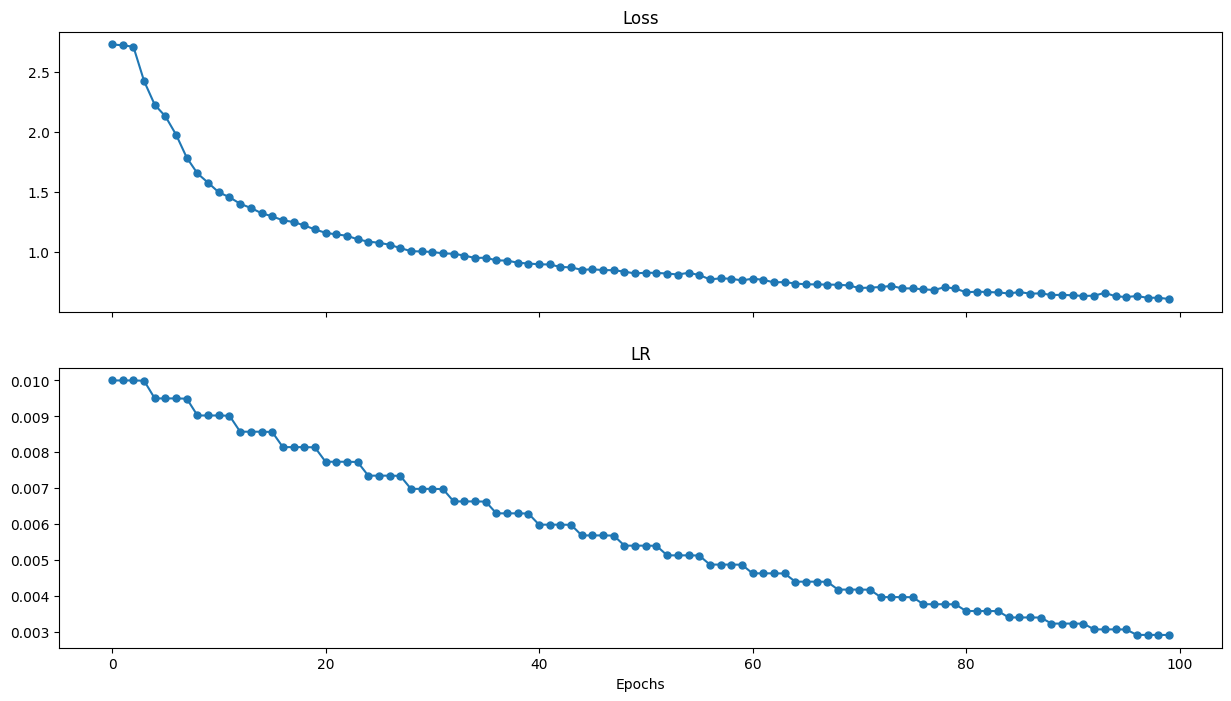

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

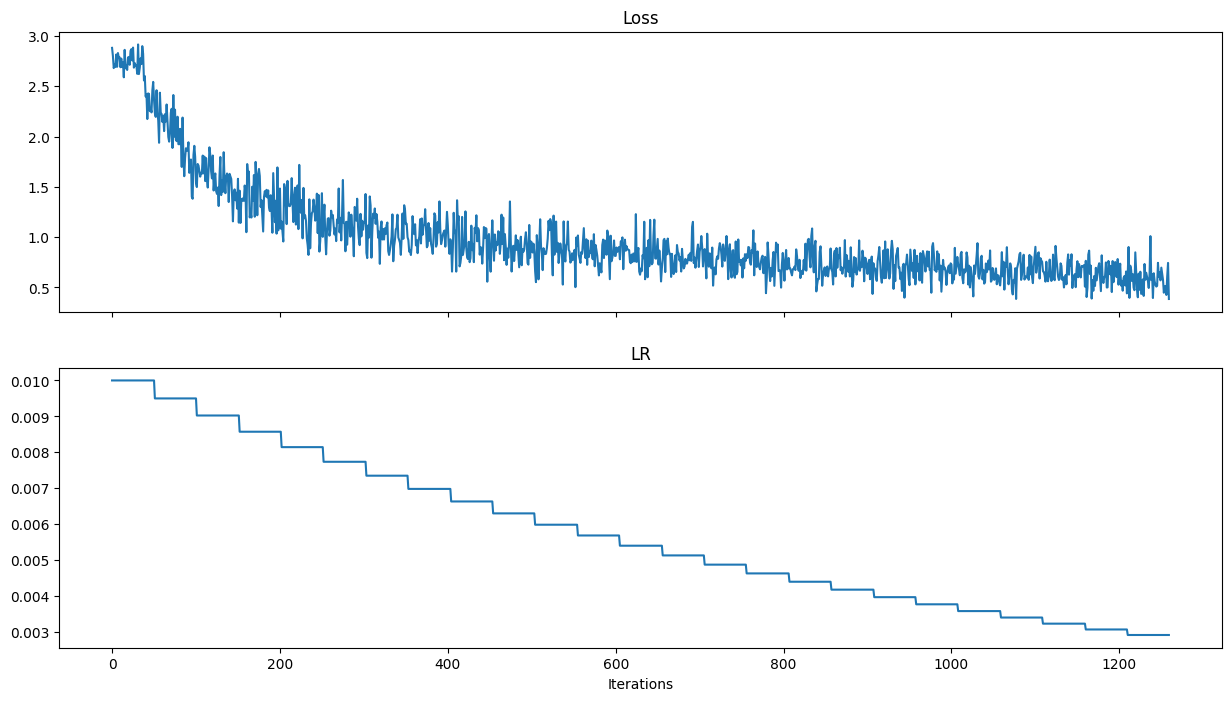

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::10])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::10])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

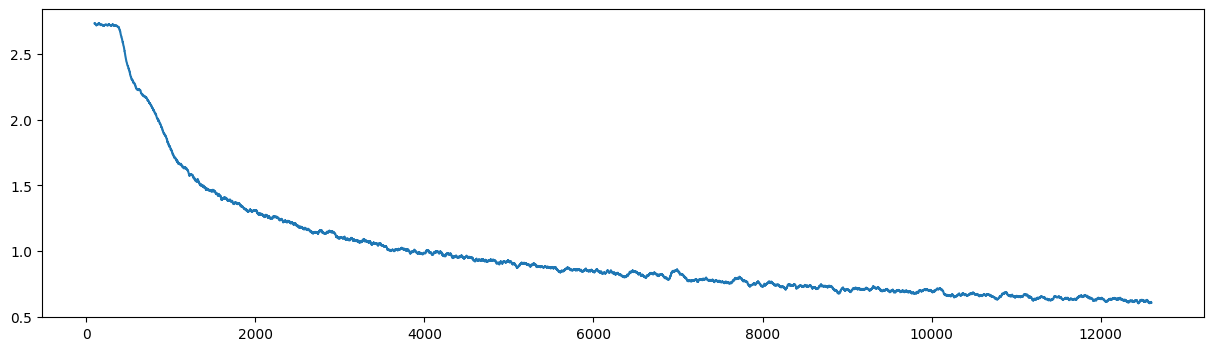

In [ ]:
window = 100
plt.figure(figsize=(15, 4))
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [ ]:
# Create the necessary directories if they don't exist
os.makedirs(os.path.dirname(path), exist_ok=True)

# Now save the model
torch.save(model.state_dict(), path)

10. Testing Model

In [ ]:
path = os.path.join("storage", "models", "language-words", "classifier.pth")
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))
#model = model.to("cpu")

<ipython-input-65-53a454f26c6c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/1004 [00:00<?, ?it/s]

In [ ]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Train Accuracy: {}".format(train_accuracy*100))
print("Test Accuracy: {}".format(test_accuracy*100))

Train Accuracy: 81.89800112086681
Test Accuracy: 72.40348692403487


In [ ]:
mat = np.array([1, 2, 3])
print(mat.shape)
print(mat[:, np.newaxis].shape)

(3,)
(3, 1)


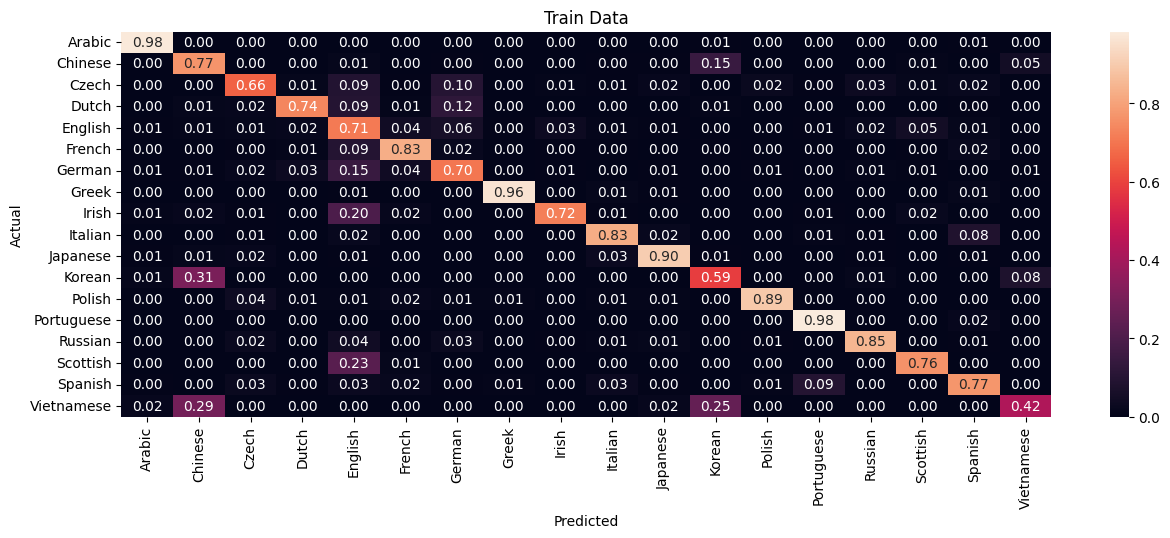

In [ ]:
labels = sorted(list(lang_to_id.keys()))
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
c_mat_train = c_mat_train / c_mat_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,5))
sns.heatmap(c_mat_train, annot=True, fmt="0.2f", xticklabels=labels, yticklabels=labels)
plt.title('Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

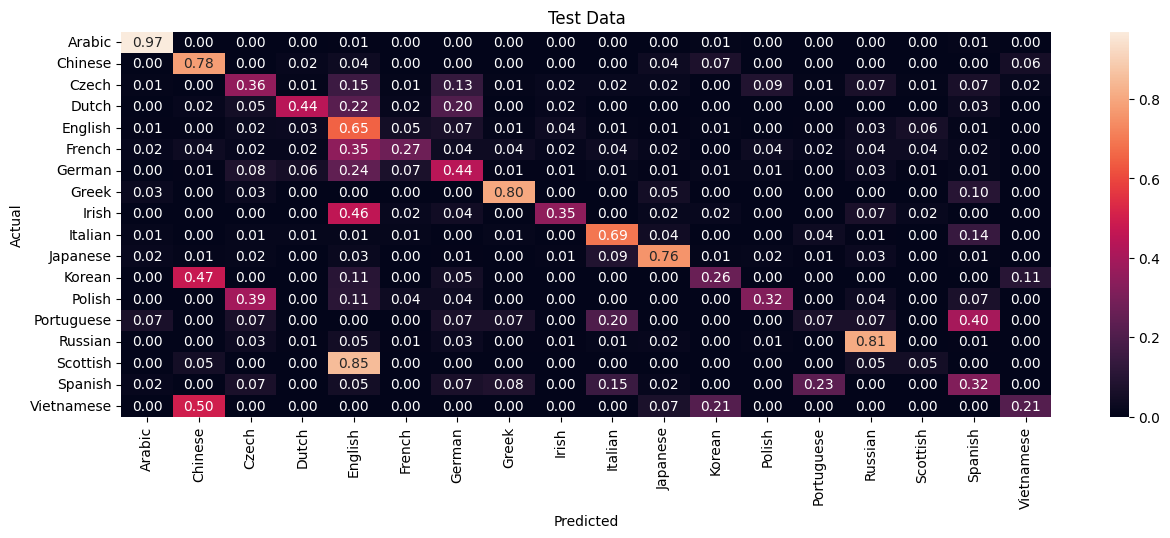

In [ ]:
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
c_mat_test = c_mat_test / c_mat_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 5))
sns.heatmap(c_mat_test, annot=True, fmt='0.2f', xticklabels=labels, yticklabels=labels)
plt.title('Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

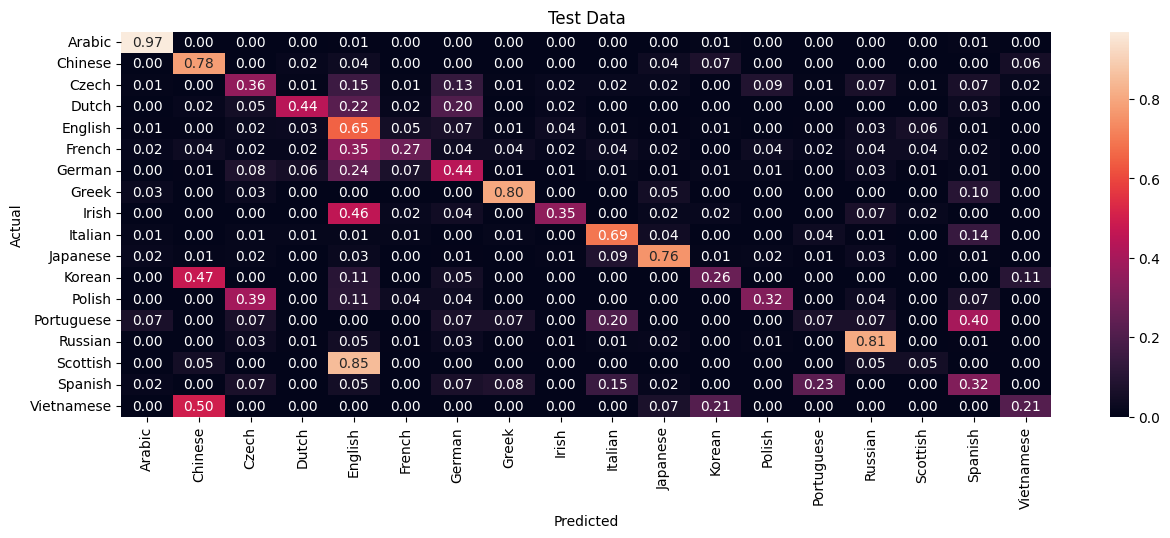

In [ ]:
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
c_mat_test = c_mat_test / c_mat_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 5))
sns.heatmap(c_mat_test, annot=True, fmt='0.2f', xticklabels=labels, yticklabels=labels)
plt.title('Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k, v in zip(labels, accuracies)}
    return accuracies

In [ ]:
compute_accuracies(c_mat_train)

{'Arabic': 0.97875,
 'Chinese': 0.766355140186916,
 'Czech': 0.6578313253012048,
 'Dutch': 0.7352941176470589,
 'English': 0.7072256305385141,
 'French': 0.8288288288288288,
 'German': 0.699481865284974,
 'Greek': 0.9631901840490797,
 'Irish': 0.7204301075268817,
 'Italian': 0.8253968253968255,
 'Japanese': 0.9041614123581336,
 'Korean': 0.5866666666666668,
 'Polish': 0.8918918918918919,
 'Portuguese': 0.9830508474576272,
 'Russian': 0.8456019133669942,
 'Scottish': 0.7625,
 'Spanish': 0.7689075630252101,
 'Vietnamese': 0.423728813559322}

In [ ]:
compute_accuracies(c_mat_test)

{'Arabic': 0.9700000000000001,
 'Chinese': 0.7777777777777778,
 'Czech': 0.3557692307692308,
 'Dutch': 0.4406779661016949,
 'English': 0.6485013623978202,
 'French': 0.27272727272727276,
 'German': 0.4413793103448276,
 'Greek': 0.8,
 'Irish': 0.3478260869565218,
 'Italian': 0.6901408450704225,
 'Japanese': 0.7575757575757578,
 'Korean': 0.26315789473684215,
 'Polish': 0.32142857142857145,
 'Portuguese': 0.06666666666666667,
 'Russian': 0.8103081827842721,
 'Scottish': 0.05,
 'Spanish': 0.31666666666666665,
 'Vietnamese': 0.21428571428571427}